# Network in Network
https://arxiv.org/abs/1312.4400

<img src="./img/network.png">

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from tqdm import tqdm
import numpy as np

In [2]:
class MLPConv(nn.Module):
    def __init__(self,ch_in, ch1, ch2, ch_out):
        super(MLPConv, self).__init__()
        self.conv1 = nn.Conv2d(ch_in, ch1, kernel_size=5, padding=2, stride=1)
        self.conv2 = nn.Conv2d(ch1, ch2, kernel_size=1, padding=0, stride=1)
        self.conv3 = nn.Conv2d(ch2, ch_out, kernel_size=1, padding=0, stride=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class NIN(nn.Module):
    def __init__(self):
        super(NIN, self).__init__()
        self.mlpc1 = MLPConv(1, 192, 192, 192)
        self.drop1 = nn.Dropout2d(0.5)
        self.pool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.mlpc2 = MLPConv(192, 192, 192, 192)
        self.drop2 = nn.Dropout2d(0.5)
        self.pool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.mlpc3 = MLPConv(192, 192, 192, 10)
        self.pool3 = nn.AvgPool2d(7, stride=1) # global average pooling
        
    def forward(self, x):
        x = self.mlpc1(x)
        x = self.pool1(self.drop1(x))
        x = self.mlpc2(x)
        x = self.pool2(self.drop2(x))
        x = self.mlpc3(x)
        x = self.pool3(x)
        x = x.view(-1, 10)
        x = F.softmax(x, dim=1)
        return x

In [3]:
from torchvision.datasets import MNIST

def normalize_image(x):
    shape = x.shape
    x = x.reshape(-1)
    mean = x.mean()
    std = x.std()
    x = (x - mean) / std
    x = x.reshape(shape)
    return x

mnist_train = MNIST("./mnist", train=True, download=True)
mnist_test = MNIST("./mnist", train=False, download=True)

# convert to numpy for my practice
x_train = mnist_train.train_data.numpy().reshape(-1,1,28,28)
x_train = np.asarray(x_train, dtype=np.float32)/255.0
# x_train = normalize_image(x_train)
y_train = mnist_train.train_labels.numpy() # not one-hot

x_test = mnist_test.test_data.numpy().reshape(-1,1,28,28)
x_test = np.asarray(x_test, dtype=np.float32)/255.0
# x_test = normalize_image(x_test)
y_test = mnist_test.test_labels.numpy()


train = torch.utils.data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test = torch.utils.data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

In [4]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def test(model, device, test_loader):
    correct = 0
    total_loss = 0
    crossentropy = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data in test_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            total_loss += crossentropy(out, y).item() # detach the history
            _, pred = torch.max(out.data, 1)
            correct += (pred==y).sum().item()

    acc = correct/len(test_loader.dataset)
    loss = total_loss/len(test_loader.dataset)
    return acc, loss

def train(model, device, train_loader, test_loader, optimizer, n_epochs):
    crossentropy = nn.CrossEntropyLoss()
    train_loss = []
    test_loss = []
    test_acc = []
    best_acc = 0

    for epoch in range(n_epochs):
        train_total_loss = 0
        for data in tqdm(train_loader):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = crossentropy(out, y)
            train_total_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_loss.append(train_total_loss / len(train_loader.dataset) )
        acc, test_loss_ave = test(model, device, test_loader)
        test_acc.append(acc)
        test_loss.append(test_loss_ave)
        if acc > best_acc:
            save_model(model, "best")
            best_acc = acc

    print("best:", best_acc)

    return train_loss, test_loss, test_acc

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(train_loss, test_loss):
    x = np.arange(len(train_loss))
    plt.plot(x, train_loss)
    plt.plot(x, test_loss)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["train", "test"])

100%|██████████| 469/469 [00:19<00:00, 24.26it/s]


best: 0.9947


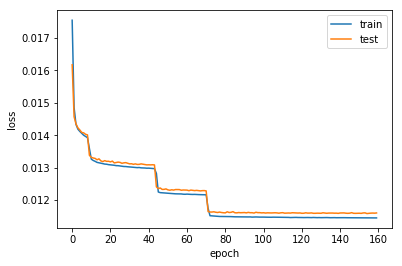

In [6]:
model = NIN()
device = torch.device("cuda:0")
model = model.to(device)
adam = opt.Adam(model.parameters(), lr=0.00005)

train_loss, test_loss, test_acc = train(model=model, device=device, train_loader=train_loader, test_loader=test_loader,
                              optimizer=adam, n_epochs=160)
plot_loss(train_loss, test_loss)

In [20]:
print("Accuracy:", max(test_acc))

Accuracy: 0.9947
